11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/50
469/469 [==============================] - 25s 49ms/step - loss: 187.7384 - val_loss: 167.3775
Epoch 2/50
469/469 [==============================] - 22s 46ms/step - loss: 163.6903 - val_loss: 159.4678
Epoch 3/50
469/469 [==============================] - 14s 29ms/step - loss: 158.3866 - val_loss: 155.9754
Epoch 4/50
469/469 [==============================] - 15s 31ms/step - loss: 154.6337 - val_loss: 153.2169
Epoch 5/50
469/469 [==============================] - 14s 29ms/step - loss: 151.9626 - val_loss: 150.9272
Epoch 6/50
469/469 [==============================] - 14s 29ms/step - loss: 150.1233 - val_loss: 149.0827
Epoch 7/50
469/469 [==============================] - 14s 31ms/step - loss: 148.7264 - val_loss: 148.0971
Epoch 8/50
469/469 [==============================] - 15s 32ms/step - loss: 147.6902 - val_loss: 147.0903
Epoch 9/50
469/469 [==============================] - 14s 31ms/step - loss: 146.8286 - 

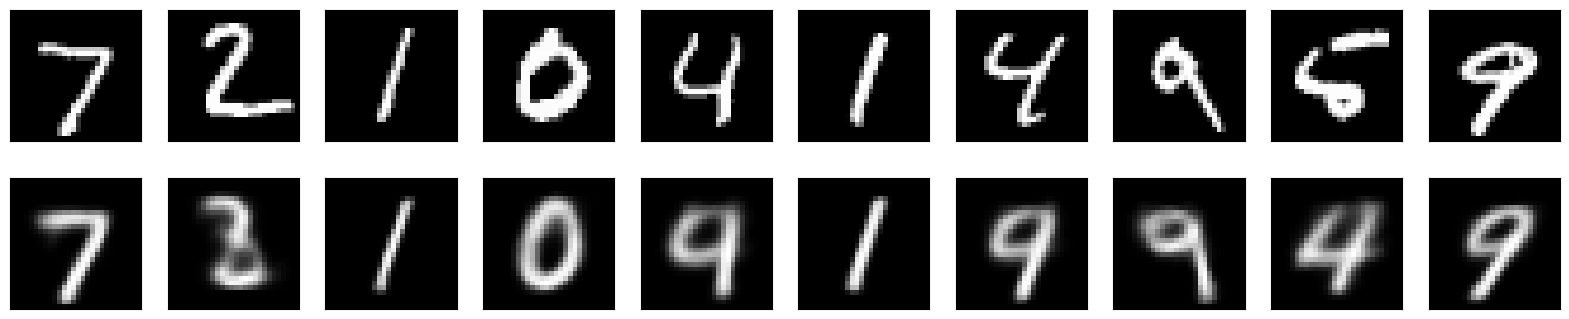

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
import tensorflow as tf

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and flatten the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Define input shape and latent dimension
input_shape = x_train.shape[1]
latent_dim = 2

# Define VAE architecture
input_img = Input(shape=(input_shape,))
hidden_layer_1 = Dense(512, activation='relu')(input_img)
hidden_layer_2 = Dense(256, activation='relu')(hidden_layer_1)
z_mean = Dense(latent_dim)(hidden_layer_2)
z_log_var = Dense(latent_dim)(hidden_layer_2)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Reparameterization trick
z = Lambda(sampling)([z_mean, z_log_var])

# Decoder layers
decoder_hidden_layer_1 = Dense(256, activation='relu')
decoder_hidden_layer_2 = Dense(512, activation='relu')
decoder_output = Dense(input_shape, activation='sigmoid')

# Decode the latent vector
decoder_hidden_1 = decoder_hidden_layer_1(z)
decoder_hidden_2 = decoder_hidden_layer_2(decoder_hidden_1)
decoded_output = decoder_output(decoder_hidden_2)

# Define the VAE model
vae = Model(input_img, decoded_output)

# Define the loss function
reconstruction_loss = tf.keras.losses.binary_crossentropy(input_img, decoded_output)
reconstruction_loss *= input_shape
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

# Compile the VAE model
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Train the VAE
vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None))

# Reconstruct some test images
reconstructed_imgs = vae.predict(x_test)

# Display original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
